# Naive implementation of SVDD in tensorflow
[Original paper by Tax & Duin](https://link.springer.com/content/pdf/10.1023%2FB%3AMACH.0000008084.60811.49.pdf)

We found out this classifier is defined by the following optimisation:

### $$ \min_{R, \xi_i} R^2 + C\sum_{i=1}^N \xi_i$$
under the constraint:

### $$ \lVert x_i - a \rVert^2 \leq R^2 + \xi_i$$

- $a$ is the center of the hypersphere
- $R$ is the radius of the hypersphere
- $\xi_i$ are slack variables that are zero if $x_i$ is in the sphere, and represent its distance to the sphere otherwise
- $C$ controls the hardness of the margin

This optimisation problem can be solved in tensorflow if we find a way to take account of the constraints.

We start by initializing the variables to be optimised against, the constant $C$ and the input placeholder

Here we work in a 2D space.

In [2]:
import tensorflow as tf
import sys
import numpy as np

DIMS = 2
INPUTS_NBR = 50
FRAC_ERR = 0.1

R = tf.Variable(tf.random_normal([], mean=10), dtype=tf.float32, name="Radius")
a = tf.Variable(tf.random_normal([DIMS], mean=5), dtype=tf.float32, name="Center")

X = tf.placeholder(tf.float32, shape=(None, DIMS), name="X")
C = tf.constant(1.0/(INPUTS_NBR*FRAC_ERR), dtype=tf.float32)

/Users/Sylvain/.pyenv/versions/3.6.4/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Define the loss

We then define the loss function. In order to account for the constraint, we choose to penalize the model if the constraint is not fullfilled. The amount of penalization is controlled by $C$.

In [3]:
constraint = tf.square(R) - tf.square(tf.norm(X - a, axis=1))
loss = tf.square(R) - C * tf.reduce_sum(tf.minimum(constraint, 0.0))

# Define the optimizer and train

In [5]:
optimizer = tf.train.AdamOptimizer(0.1)
train = optimizer.minimize(loss)

EPOCHS = 5000

inputs = np.random.normal(3*np.ones(DIMS), scale=1, size=(INPUTS_NBR, DIMS))

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for e in range(EPOCHS):
        _, l, R1, a1 = sess.run([train, loss, R, a], feed_dict={X: inputs})
        
        towrite = "\r{0:4.1f} %, Loss: {1:7.4f}, R: {2:7.4f}, a:".format(e / EPOCHS * 100, l, R1) + str(a1)
        sys.stdout.write(towrite)
        sys.stdout.flush()

100.0 %, Loss:  7.7201, R:  2.4675, a:[3.1994038 2.86     ]

# Visualize the outputs

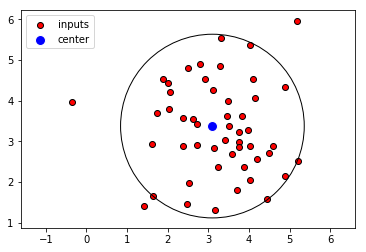

In [6]:
import matplotlib.pyplot as plt

xx, yy = np.meshgrid(np.linspace(-5, 5, 500), np.linspace(-5, 5, 500))

fig = plt.gcf()
ax = fig.gca()

s1 = plt.scatter(inputs[:, 0], inputs[:, 1], c='red', edgecolors='k')
s2 = plt.scatter(a1[0], a1[1], c='blue', s=100, edgecolors='w')
c = plt.Circle(tuple(a1), R1, fill=False)
ax.add_patch(c)

plt.axis('equal')

plt.legend([s1, s2],
           ["inputs", "center"],
           loc="upper left")
plt.show()